# Определение возраста покупателей

## Исследовательский анализ данных

Магазин хочет с помощью камеры определять возраст покупателей. Нужно обучить этому модель. Имеются фотографии людей с указанием возраста.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


С помощью ImageDataGenerator загрузили поток фотографий из датасета  `faces`.

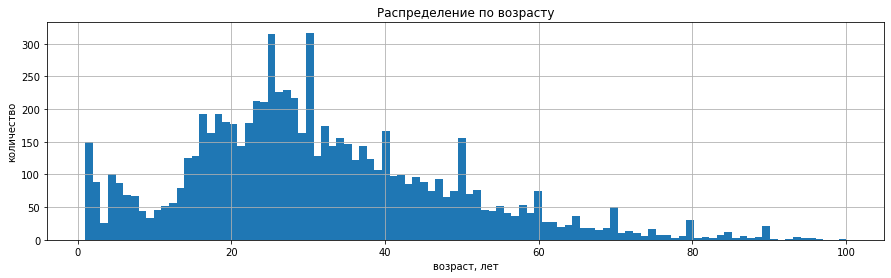

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.hist(bins=100, figsize=(15,4))
plt.title('Распределение по возрасту')
plt.xlabel('возраст, лет')
plt.ylabel('количество')
plt.show()
labels.info()
labels.head()

У нас 7591 фото. Большинству людей в выборке около 30. Модель хорошо обучится определять возраст от 20 до 40 (т.к. много таких фото), у модели могут быть трудности с людьми за 80, т.к. очень мало таких фоток.

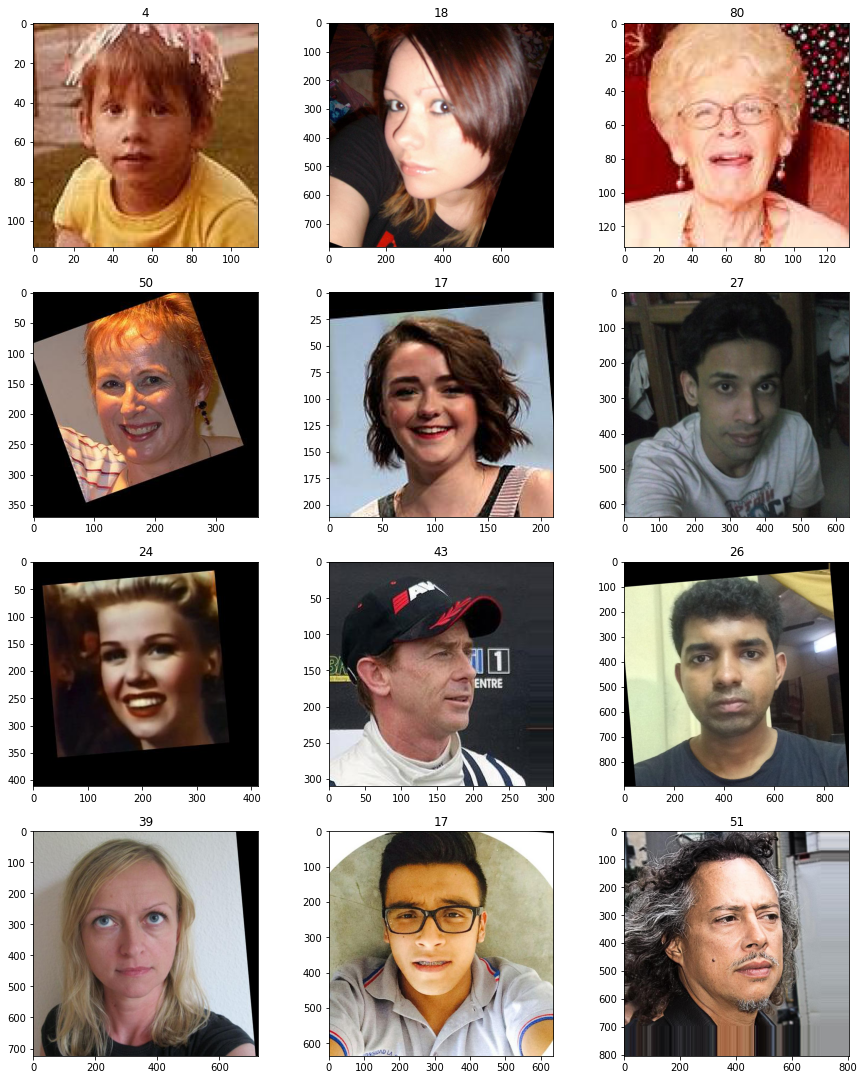

In [ ]:
fig, _axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 19))
axs = _axs.flatten()
for i in range(10):
    image = Image.open('/datasets/faces/final_files/00000'+str(i)+'.jpg')
    image_array = np.array(image)
    axs[i].imshow(image_array);
    axs[i].set_title(labels['real_age'][i])
for i in range(10, 12):
    image = Image.open('/datasets/faces/final_files/0000'+str(i)+'.jpg')
    image_array = np.array(image)
    axs[i].imshow(image_array);
    axs[i].set_title(labels['real_age'][i])

Люди на фото соответствуют указанному для них возрасту. Качество изображений не очень чёткое. Лица видны крупным планом, с разными выражениями лиц, взглядами в разных направлениях (примерно как и увидит покупателей камера магазина). Есть люди обоих полов, разного возраста (дети, молодёжь, среднего и постарше, старики), разной расы, в очках, в шапочке, с бородой и пр., некоторые фото слегка развёрнуты (видимо, датасет собирался из интернета и фото специально разворачивали, чтоб приблизить к виду человека в движении, как их должна увидеть камера).

## Обучение модели

(Код в этом разделе запускался на отдельном GPU-сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path+'/final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                    directory=path+'/final_files',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Скопирован вывод с GPU:

```

pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s

2024-03-30 12:46:06.475059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

Train for 178 steps, validate for 60 steps

Epoch 1/10

2024-03-30 12:46:18.452214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2024-03-30 12:46:18.801884: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 50s - loss: 236.7638 - mae: 11.0325 - val_loss: 639.1011 - val_mae: 20.2949

Epoch 2/10

178/178 - 41s - loss: 59.7576 - mae: 5.8891 - val_loss: 698.6281 - val_mae: 21.3563

Epoch 3/10

178/178 - 41s - loss: 30.4442 - mae: 4.2280 - val_loss: 223.7300 - val_mae: 10.9220

Epoch 4/10

178/178 - 42s - loss: 19.4820 - mae: 3.4002 - val_loss: 105.1733 - val_mae: 7.7720

Epoch 5/10

178/178 - 40s - loss: 15.4063 - mae: 3.0085 - val_loss: 80.9428 - val_mae: 6.8016

Epoch 6/10

178/178 - 39s - loss: 11.8994 - mae: 2.6679 - val_loss: 84.1288 - val_mae: 6.7167

Epoch 7/10

178/178 - 39s - loss: 9.7832 - mae: 2.3702 - val_loss: 66.3212 - val_mae: 6.1934

Epoch 8/10

178/178 - 39s - loss: 8.6263 - mae: 2.2299 - val_loss: 66.8119 - val_mae: 6.1272

Epoch 9/10

178/178 - 39s - loss: 7.5977 - mae: 2.0867 - val_loss: 75.9177 - val_mae: 6.4576

Epoch 10/10

178/178 - 40s - loss: 6.6686 - mae: 1.9530 - val_loss: 70.2870 - val_mae: 6.5288

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 11s - loss: 70.2870 - mae: 6.5288

Test MAE: 6.5288


```

## Анализ обученной модели

В результате обучения модели с архитектурой ResNet50 и алгоритмом Adam (learning_rate=0.0001) на 10 эпохах получилось требуемое качество - метрика MAE на валидационной выборке 6.5288, что меньше 8 (даже меньше 7). Модель хорошо обучилась на тренировочных данных. Причём хватило бы и 5 эпох - после 5 метрика уже почти не менялась (а до того очень хорошо снижалась на новой эпохе).